Max moment: 69445.33 Nmm
Location of leftmost train wheel for max moment: 128.00 mm
Max shear: 257.00 N
Location of leftmost train wheel for max shear: 1.00 mm
Max I: 1333760.71 mm^4
Ybar at max I: 102.23 mm
Factors of Safety:
  Matboard Tensile: 5.64
  Matboard Compressive: 3.26
  Matboard Shear: 3.48
  Glue Shear: 8.48
  Buckling Case 1: 7.52
  Buckling Case 2: 51.16
  Buckling Case 3: 16.52
  Shear Buckling: 3.47

Failure load: 1305.53 N

Critical failure mode: Matboard Compressive


C:\Users\Nelson Siu\AppData\Local\Temp\ipykernel_15004\3989635086.py:392: RuntimeWarning: divide by zero encountered in divide
  (t_thickness / (ybottoms - top_flange_constant_thickness)) ** 2 + (t_thickness / diaphragm_distances_discretized) ** 2


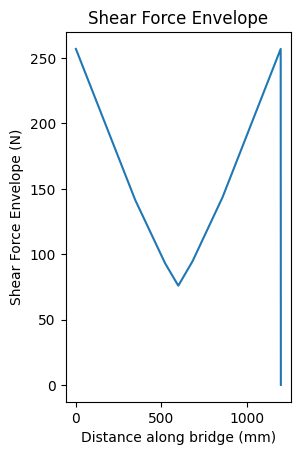

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# This script computes the structural analysis of a bridge under train loading.
# It calculates the Shear Force Diagram (SFD) and Bending Moment Diagram (BMD),
# computes the geometric properties of the bridge's cross sections,
# calculates the applied stresses, material capacities, factors of safety,
# and outputs relevant plots.

# %% 0. Initialize Parameters
L = 1200  # Length of bridge in mm
n = 1200  # Discretize into 1 mm segments
P = 400   # Total weight of train [N], assuming all are freight trains
x = np.linspace(0, L, n + 1)  # x-axis: generate n + 1 evenly spaced points from 0 to L

# Cross sections are defined by an nx3 matrix. Each row represents a rectangle.
# Each rectangle has:
# width = b, height = h, centroid position = ybar
# **Coordinates measured with right and down positive**

# Design 0 (Initial Cross Section)
design0_section = np.array([
    [100, 1.27, 1.27 / 2],  # Top flange: width=100mm, height=1.27mm, centroid at h/2
    [80, 1.27, 1.27 / 2 + 75],  # Bottom flange
    [1.27 * 2, 75 - 1.27, (75 - 1.27) / 2 + 1.27],  # Web
    [10, 1.27, 3 * 1.27 / 2],  # Glue tabs
    [10, 0.0001, 1.27],  # Glue width (very thin rectangle)
])

# Iteration 1 Cross Section
section_v2 = np.array([
    [100, 1.27 * 2, 1.27],  # Top flange
    [80, 1.27, 1.27 / 2 + 75 + 1.27],  # Bottom flange
    [1.27 * 2, 75 - 1.27, (75 - 1.27) / 2 + 2 * 1.27],  # Web
    [10, 1.27, 2 * 1.27 + 1.27 / 2],  # Glue tabs
    [10, 0.0001, 2 * 1.27],  # Glue width
])

# Iteration 2 Cross Section
section_v3 = np.array([
    [100, 1.27 * 2, 1.27],  # Top flange
    [1.27 * 2, 75, 75 / 2 + 2 * 1.27],  # Web
    [10, 1.27, 2 * 1.27 + 1.27 / 2],  # Glue tabs
    [10, 0.0001, 2 * 1.27],  # Glue width
])

# Iteration 10 Cross Sections
section1_v11 = np.array([
    [100, 1.27 * 2, 1.27],  # Top flange
    [60, 0.0001, 2 * 1.27 + 1.27 / 2],  # Gap in web
    [1.27 * 2, 120 - 2 * 1.27, (120 - 2 * 1.27) / 2 + 2 * 1.27],  # Web
    [20, 1.27, 2 * 1.27 + 1.27 / 2],  # Glue tabs
    [10, 0.0001, 2 * 1.27],
])

section2_v11 = np.array([
    [100, 1.27 * 2, 1.27],
    [60, 0.0001, 2 * 1.27 + 1.27 / 2],
    [1.27 * 2, 135, 135 / 2 + 2 * 1.27],
    [20, 1.27, 2 * 1.27 + 1.27 / 2],
    [10, 0.0001, 2 * 1.27],
])

section3_v11 = np.array([
    [100, 1.27 * 2, 1.27],
    [60, 0.0001, 2 * 1.27 + 1.27 / 2],
    [1.27 * 2, 120 - 2 * 1.27, (120 - 2 * 1.27) / 2 + 2 * 1.27],
    [20, 1.27, 2 * 1.27 + 1.27 / 2],
    [10, 0.0001, 2 * 1.27],
])

# List of all cross sections used along the bridge length
cross_sections_list = [
    section3_v11, section3_v11, section1_v11, section2_v11,
    section2_v11, section1_v11, section3_v11, section3_v11
]

# Define the positions along the bridge where each cross section applies
cross_section_positions = [0, 10, 11, 500, 700, 1189, 1190, 1200]

# Define top flange parameters
top_flange_constant_thickness = 1.27 * 2  # Top flange thickness (constant)
top_flange_constant_width = 80            # Top flange width (constant)
top_flange_free_thickness = 1.27 * 2      # Thickness of the free edge of the top flange
top_flange_free_width = 10                # Width of the free edge of the top flange

# Define glue joints
glue_joint_heights = [2 * 1.27, 1.27]
number_of_glue_joints = len(glue_joint_heights)
number_of_cross_sections = len(cross_sections_list)

# Distance between diaphragms (assumed constant for simplicity)
diaphragm_distances = [118, 177, 118]
diaphragm_locations = [0, 246, 945, 1200]

# %% 1. Compute SFD, BMD under train loading

# Positions of train wheels (relative to the start of the bridge, in mm)
train_wheel_positions = np.array([52, 228, 392, 568, 732, 908]) - 52

# Train load per wheel for two different load cases
# Load Case 1: Uniformly distributed loads
train_load_case1 = np.ones(6) * (P / 6)

# Load Case 2: Increased load on the first two wheels
train_load_case2 = np.array([1.35, 1.35, 1, 1, 1, 1]) * (P / 6)

# Select the load case to be used in the analysis
train_loads = train_load_case1

# Array of positions the end of the train can take, in intervals of 1mm
# From -train_wheel_positions[-1] to L
train_positions = np.arange(-train_wheel_positions[-1], L + 1, 1)
number_of_train_positions = len(train_positions)

# Initialize arrays to store Shear Force Diagram (SFD) and Bending Moment Diagram (BMD)
sfd_all_positions = np.zeros((number_of_train_positions, n + 1))  # SFD for each train position
bmd_all_positions = np.zeros((number_of_train_positions, n + 1))  # BMD for each train position

# Initialize variables to track maximum moment and shear
max_moment = 0
max_moment_train_position = 0

max_shear = 0
max_shear_train_position = 0

# Loop over each possible train position to compute SFD and BMD
for i in range(number_of_train_positions):
    # Current position of the train (start location)
    current_train_wheel_positions = train_positions[i] + train_wheel_positions

    # Filter out train wheels that are not on the bridge
    wheels_on_bridge = (current_train_wheel_positions >= 0) & (current_train_wheel_positions <= L)
    current_wheel_positions = current_train_wheel_positions[wheels_on_bridge]
    current_wheel_loads = train_loads[wheels_on_bridge]  # Corresponding loads for wheels on bridge

    # Sum of moments at support A (left support) to find reaction at support B (right support)
    reaction_B = np.sum(current_wheel_positions * current_wheel_loads) / L

    # Sum of vertical forces to find reaction at support A
    reaction_A = np.sum(current_wheel_loads) - reaction_B

    # Construct applied loads along the bridge
    applied_loads = np.zeros(n + 1)
    # Indices of applied loads (convert positions to indices)
    load_indices = np.round(current_wheel_positions / L * n).astype(int)
    applied_loads[load_indices] = -current_wheel_loads  # Apply negative load at wheel positions
    applied_loads[0] += reaction_A  # Apply reaction at support A
    applied_loads[n] += reaction_B  # Apply reaction at support B

    # Compute Shear Force Diagram (SFD) by integrating the applied loads
    sfd_all_positions[i, :] = np.cumsum(applied_loads)

    # Compute Bending Moment Diagram (BMD) by integrating the SFD
    bmd_all_positions[i, :] = np.cumsum(sfd_all_positions[i, :])

    # Update maximum moment and shear if current values are larger
    current_max_moment = np.max(bmd_all_positions[i, :])
    if current_max_moment >= max_moment:
        max_moment = current_max_moment
        max_moment_train_position = train_positions[i]

    current_max_shear = np.max(sfd_all_positions[i, :])
    if current_max_shear > max_shear:
        max_shear = current_max_shear
        max_shear_train_position = train_positions[i]

# Compute the envelopes of maximum shear force and bending moment across all train positions
shear_force_envelope = np.max(np.abs(sfd_all_positions), axis=0)
bending_moment_envelope = np.max(bmd_all_positions, axis=0)

# Plot the Shear Force Envelope
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(x, shear_force_envelope)
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Shear Force Envelope (N)')
plt.title('Shear Force Envelope')

print(f"Max moment: {max_moment:.2f} Nmm")
print(f"Location of leftmost train wheel for max moment: {max_moment_train_position:.2f} mm")

print(f"Max shear: {max_shear:.2f} N")
print(f"Location of leftmost train wheel for max shear: {max_shear_train_position:.2f} mm")

# %% 2. Compute geometric properties of cross sections

# Discretize cross sections along the bridge length
# One cross section per mm (n + 1 points)
cross_sections_discretized = [None] * (n + 1)

# Assign the first cross section at the corresponding position
index = int(round(cross_section_positions[0] / L * n))
cross_sections_discretized[index] = cross_sections_list[0]

# Interpolate between cross sections
for i in range(number_of_cross_sections - 1):
    # Indices corresponding to the positions of the cross sections
    idx1 = int(round(cross_section_positions[i] / L * n))
    idx2 = int(round(cross_section_positions[i + 1] / L * n))

    # Compute the ratio for interpolation between cross sections
    section_difference = cross_sections_list[i + 1] - cross_sections_list[i]
    total_steps = idx2 - idx1
    section_step = section_difference / total_steps

    # Assign the starting and ending cross sections
    cross_sections_discretized[idx1] = cross_sections_list[i]
    cross_sections_discretized[idx2] = cross_sections_list[i + 1]

    # Interpolate between cross sections
    for j in range(1, total_steps):
        cross_sections_discretized[idx1 + j] = cross_sections_list[i] + section_step * j

# Adjust cross sections between specific indices
for i in range(1 + 292 - 1, n + 1 - 292):
    if cross_sections_discretized[i] is not None and cross_sections_discretized[i].shape[0] > 1:
        cross_sections_discretized[i][1, 1] = 1.27  # Modify the height of the second rectangle

# Initialize arrays to store geometric properties
ybottoms = np.zeros(n + 1)            # Distance from centroid to bottom fiber
centroid_y_positions = np.zeros(n + 1)  # Centroid positions along y-axis
second_moments_of_area = np.zeros(n + 1)  # Second moment of area (I)
first_moments_centroid = np.zeros(n + 1)  # First moment of area about centroid
first_moments_glues = np.zeros((number_of_glue_joints, n + 1))  # First moments at glue joints
cross_sectional_areas = np.zeros(n + 1)     # Cross-sectional areas

# Loop over each discretized cross section to compute geometric properties
for i in range(n + 1):
    if cross_sections_discretized[i] is None:
        continue

    # Compute centroid y-position (ybar)
    sum_area_times_distance = 0
    sum_areas = 0
    for j in range(cross_sections_discretized[i].shape[0]):
        # Extract properties of each rectangle in the cross section
        width = cross_sections_discretized[i][j, 0]
        height = cross_sections_discretized[i][j, 1]
        y_position = cross_sections_discretized[i][j, 2]
        area = width * height
        sum_area_times_distance += area * y_position
        sum_areas += area
        cross_sectional_areas[i] += area

    # Compute centroid position (ybar)
    centroid_y_positions[i] = sum_area_times_distance / sum_areas

    # Compute distance from centroid to bottom fiber
    y_positions_rectangles = cross_sections_discretized[i][:, 1] / 2 + cross_sections_discretized[i][:, 2]
    ybottoms[i] = max(y_positions_rectangles)

    # Compute second moment of area (I)
    total_I = 0
    for j in range(cross_sections_discretized[i].shape[0]):
        width = cross_sections_discretized[i][j, 0]
        height = cross_sections_discretized[i][j, 1]
        y_position = cross_sections_discretized[i][j, 2]
        local_I = width * height ** 3 / 12
        area = width * height
        distance = abs(y_position - centroid_y_positions[i])
        total_I += local_I + area * distance ** 2
    second_moments_of_area[i] = total_I

    # Compute first moment of area about centroid (Q_centroid)
    Qc = 0
    for j in range(cross_sections_discretized[i].shape[0]):
        width = cross_sections_discretized[i][j, 0]
        height = cross_sections_discretized[i][j, 1]
        y_position = cross_sections_discretized[i][j, 2]
        y1 = y_position - height / 2
        y2 = y_position + height / 2
        if y1 < centroid_y_positions[i]:
            area = width * (min(y2, centroid_y_positions[i]) - y1)
            centroid_Y = (min(y2, centroid_y_positions[i]) + y1) / 2
            Qc += area * (centroid_y_positions[i] - centroid_Y)
    first_moments_centroid[i] = Qc

    # Compute first moments at glue joints (Q_glues)
    for j in range(number_of_glue_joints):
        Q_glue = 0
        for k in range(cross_sections_discretized[i].shape[0]):
            width = cross_sections_discretized[i][k, 0]
            height = cross_sections_discretized[i][k, 1]
            y_position = cross_sections_discretized[i][k, 2]
            y1 = y_position - height / 2
            y2 = y_position + height / 2
            if y1 < glue_joint_heights[j]:
                area = width * (min(y2, glue_joint_heights[j]) - y1)
                centroid_Y = (min(y2, glue_joint_heights[j]) + y1) / 2
                Q_glue += area * (centroid_y_positions[i] - centroid_Y)
        first_moments_glues[j, i] = Q_glue

# Initialize arrays for maximum width 'b' at centroid and glue joints
width_at_centroid_top = np.zeros(n + 1)
width_at_centroid_bottom = np.zeros(n + 1)

width_at_glues_top = np.zeros((number_of_glue_joints, n + 1))
width_at_glues_bottom = np.zeros((number_of_glue_joints, n + 1))

# Loop through each discretized cross section to find minimum width at centroid and glue joints
for i in range(n + 1):
    if cross_sections_discretized[i] is None:
        continue
    b_bottom = 0
    b_top = 0
    for j in range(cross_sections_discretized[i].shape[0]):
        width = cross_sections_discretized[i][j, 0]
        height = cross_sections_discretized[i][j, 1]
        y_position = cross_sections_discretized[i][j, 2]
        y_centroid = round(centroid_y_positions[i], 2)
        y1 = round(y_position - (height / 2), 2)
        y2 = round(y_position + (height / 2), 2)
        if y2 >= y_centroid and y1 < y_centroid:
            b_bottom += width
        if y2 > y_centroid and y1 <= y_centroid:
            b_top += width
    width_at_centroid_top[i] = b_top
    width_at_centroid_bottom[i] = b_bottom
    for j in range(number_of_glue_joints):
        b_bottom = 0
        b_top = 0
        for k in range(cross_sections_discretized[i].shape[0]):
            width = cross_sections_discretized[i][k, 0]
            height = cross_sections_discretized[i][k, 1]
            y_position = cross_sections_discretized[i][k, 2]
            y1 = round(y_position - (height / 2), 5)
            y2 = round(y_position + (height / 2), 5)
            glue_height = round(glue_joint_heights[j], 5)
            if y2 > glue_height and y1 < glue_height:
                b_bottom += width
            if y2 > glue_height and y1 <= glue_height:
                b_top += width
        width_at_glues_top[j, i] = b_top
        width_at_glues_bottom[j, i] = b_bottom

# Discretize diaphragm distances along the bridge length
diaphragm_distances_discretized = np.zeros(n + 1)

for i in range(len(diaphragm_locations) - 1):
    idx1 = int(diaphragm_locations[i])
    idx2 = int(diaphragm_locations[i + 1])
    diaphragm_distances_discretized[idx1:idx2] = diaphragm_distances[i]

# Find the maximum second moment of area and its position
max_I = np.max(second_moments_of_area)
max_I_index = np.argmax(second_moments_of_area)
print(f"Max I: {max_I:.2f} mm^4")
print(f"Ybar at max I: {ybottoms[max_I_index] - centroid_y_positions[max_I_index]:.2f} mm")

# %% 3. Calculate Applied Stresses

# Compute normal stresses at the top and bottom fibers due to bending moment
stress_top_fiber = centroid_y_positions * bending_moment_envelope / second_moments_of_area
stress_bottom_fiber = (ybottoms - centroid_y_positions) * bending_moment_envelope / second_moments_of_area

# Compute shear stress at the neutral axis (centroid)
shear_stress_centroid = shear_force_envelope * first_moments_centroid / second_moments_of_area / np.minimum(width_at_centroid_bottom, width_at_centroid_top)

# Compute shear stress at glue joints
shear_stress_glues = np.zeros((number_of_glue_joints, n + 1))
for j in range(number_of_glue_joints):
    shear_stress_glues[j, :] = shear_force_envelope * first_moments_glues[j, :] / second_moments_of_area / np.minimum(width_at_glues_top[j, :], width_at_glues_bottom[j, :])

# Maximum shear stress at glue joints
max_shear_stress_glues = np.max(shear_stress_glues, axis=0)

# %% 4. Material and Buckling Capacities

# Material properties
E_modulus = 4000    # Elastic modulus (N/mm^2)
poisson_ratio = 0.2  # Poisson's ratio
t_thickness = 1.27   # Thickness of the material (mm)

# Applied stresses
tensile_stress = stress_bottom_fiber
compressive_stress = stress_top_fiber
max_shear_stress = shear_stress_centroid

# Buckling calculations
# Buckling case 1: Middle of top flange (simply supported)
buckling_stress_case1 = 4 * np.pi ** 2 * E_modulus / (12 * (1 - poisson_ratio ** 2)) * ((top_flange_constant_thickness / top_flange_constant_width) ** 2)

# Buckling case 2: Sides of top flange (simply supported)
buckling_stress_case2 = 0.4254 * np.pi ** 2 * E_modulus / (12 * (1 - poisson_ratio ** 2)) * ((top_flange_free_thickness / top_flange_free_width) ** 2)

# Buckling case 3: Webs (simply supported)
buckling_stress_case3 = 6 * np.pi ** 2 * E_modulus / (12 * (1 - poisson_ratio ** 2)) * (t_thickness / (centroid_y_positions - top_flange_constant_thickness)) ** 2

# Shear buckling
buckling_shear_stress = 5 * np.pi ** 2 * E_modulus / (12 * (1 - poisson_ratio ** 2)) * (
    (t_thickness / (ybottoms - top_flange_constant_thickness)) ** 2 + (t_thickness / diaphragm_distances_discretized) ** 2
)

# %% 5. Factors of Safety (FOS)

# Factors of Safety for different failure modes
FOS_tension = 30 / tensile_stress           # Matboard tensile strength
FOS_compression = 6 / compressive_stress    # Matboard compressive strength
FOS_shear = 4 / max_shear_stress            # Matboard shear strength
FOS_glue_shear = 2 / max_shear_stress_glues  # Glue shear strength
FOS_buckling_case1 = buckling_stress_case1 / compressive_stress  # Buckling case 1
FOS_buckling_case2 = buckling_stress_case2 / compressive_stress  # Buckling case 2
FOS_buckling_case3 = buckling_stress_case3 / compressive_stress  # Buckling case 3
FOS_shear_buckling = buckling_shear_stress / np.abs(max_shear_stress)  # Shear buckling

# %% 6. Min FOS and the failure load Pfail

# Step 1: Collect the minimum FOS from all failure modes
FOS_list = [
    np.min(FOS_tension),        # Matboard Tensile
    np.min(FOS_compression),    # Matboard Compressive
    np.min(FOS_shear),          # Matboard Shear
    np.min(FOS_glue_shear),     # Glue Shear
    np.min(FOS_buckling_case1), # Buckling Case 1
    np.min(FOS_buckling_case2), # Buckling Case 2
    np.min(FOS_buckling_case3), # Buckling Case 3
    np.min(FOS_shear_buckling), # Shear Buckling
]

# Step 2: Find the minimum FOS among all failure modes
min_FOS = np.min(FOS_list)

# Step 3: Calculate the failure load
failure_load = np.sum(train_loads) * min_FOS

# Step 4: Define the list of failure mode names
failure_modes = [
    'Matboard Tensile',
    'Matboard Compressive',
    'Matboard Shear',
    'Glue Shear',
    'Buckling Case 1',
    'Buckling Case 2',
    'Buckling Case 3',
    'Shear Buckling'
]

# Step 5: Find the index of the minimum FOS
failure_mode_index = FOS_list.index(min_FOS)

# Step 6: Retrieve the critical failure mode
critical_failure_mode = failure_modes[failure_mode_index]

# Step 7: Print Factors of Safety and Failure Load
print('Factors of Safety:')
print(f'  Matboard Tensile: {FOS_list[0]:.2f}')
print(f'  Matboard Compressive: {FOS_list[1]:.2f}')
print(f'  Matboard Shear: {FOS_list[2]:.2f}')
print(f'  Glue Shear: {FOS_list[3]:.2f}')
print(f'  Buckling Case 1: {FOS_list[4]:.2f}')
print(f'  Buckling Case 2: {FOS_list[5]:.2f}')
print(f'  Buckling Case 3: {FOS_list[6]:.2f}')
print(f'  Shear Buckling: {FOS_list[7]:.2f}')
print(f'\nFailure load: {failure_load:.2f} N')

# Step 8: Print the critical failure mode
print(f'\nCritical failure mode: {critical_failure_mode}')

# %% 7. Compute Vfail and Mfail for each failure mode

# Failure bending moment and shear force for each failure mode
moment_failure_tension = FOS_tension * bending_moment_envelope
moment_failure_compression = FOS_compression * bending_moment_envelope
shear_failure_shear = FOS_shear * shear_force_envelope
shear_failure_glue = FOS_glue_shear * shear_force_envelope
moment_failure_buckling_case1 = FOS_buckling_case1 * bending_moment_envelope
moment_failure_buckling_case2 = FOS_buckling_case2 * bending_moment_envelope
moment_failure_buckling_case3 = FOS_buckling_case3 * bending_moment_envelope
shear_failure_buckling = FOS_shear_buckling * shear_force_envelope

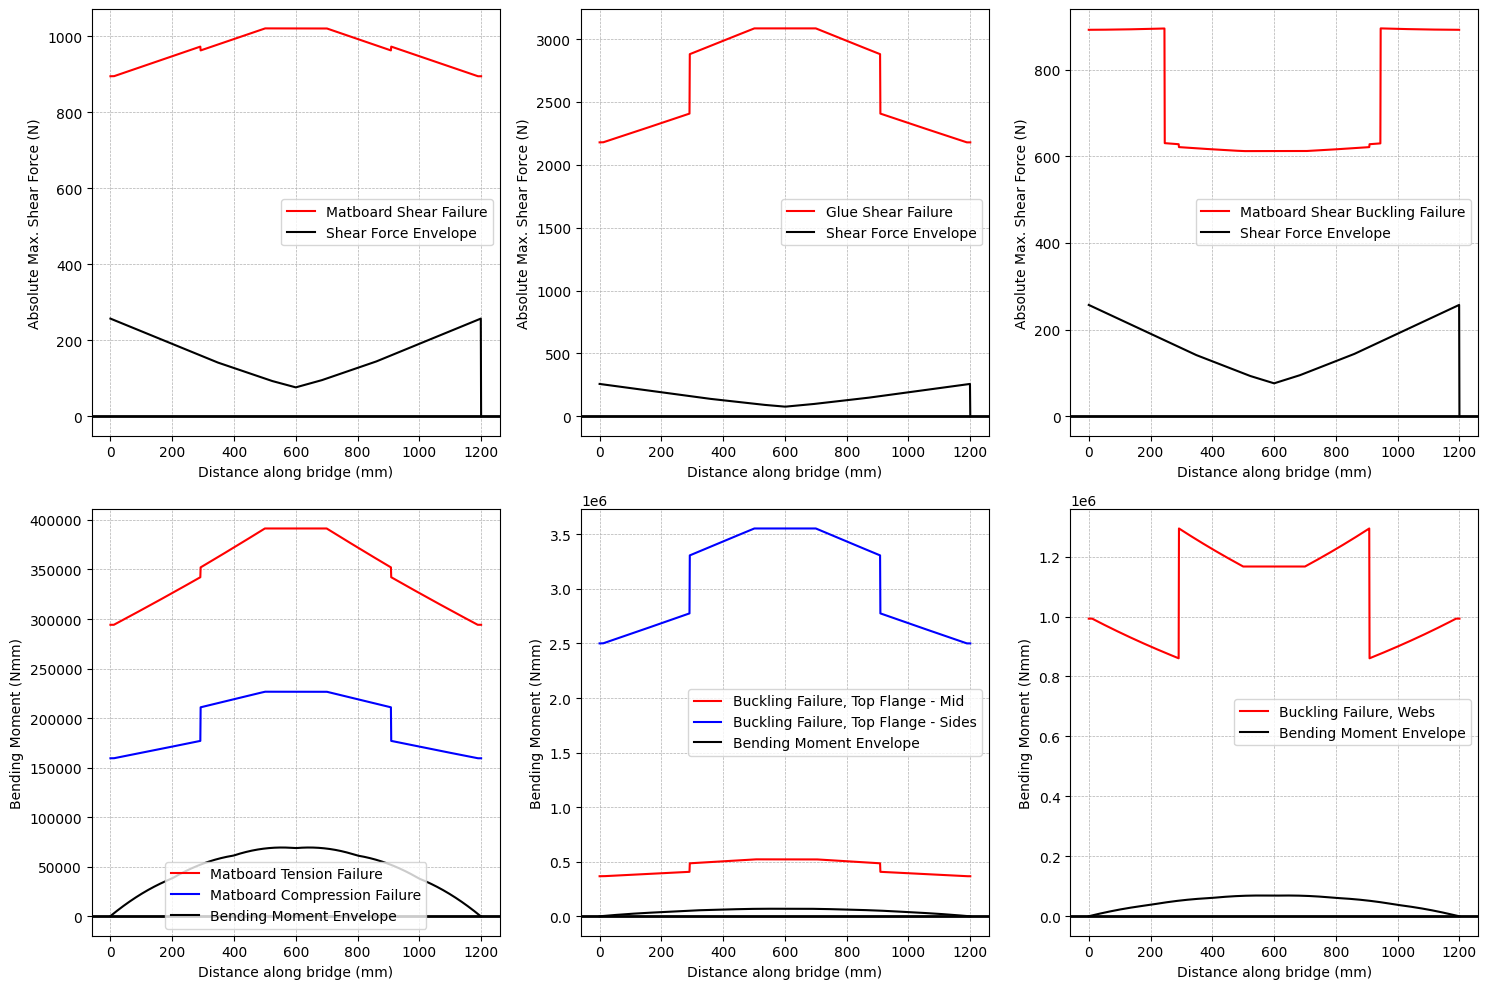

In [5]:
# %% 8. Output plots of Vfail and Mfail

plt.figure(figsize=(15, 10))

# Plot Matboard Shear Failure
plt.subplot(2, 3, 1)
plt.plot(x, shear_failure_shear, 'r', label='Matboard Shear Failure')
plt.plot(x, shear_force_envelope, 'k', label='Shear Force Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Absolute Max. Shear Force (N)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Glue Shear Failure
plt.subplot(2, 3, 2)
plt.plot(x, shear_failure_glue, 'r', label='Glue Shear Failure')
plt.plot(x, shear_force_envelope, 'k', label='Shear Force Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Absolute Max. Shear Force (N)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Matboard Shear Buckling Failure
plt.subplot(2, 3, 3)
plt.plot(x, shear_failure_buckling, 'r', label='Matboard Shear Buckling Failure')
plt.plot(x, shear_force_envelope, 'k', label='Shear Force Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Absolute Max. Shear Force (N)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Matboard Tension and Compression Failure
plt.subplot(2, 3, 4)
plt.plot(x, moment_failure_tension, 'r', label='Matboard Tension Failure')
plt.plot(x, moment_failure_compression, 'b', label='Matboard Compression Failure')
plt.plot(x, bending_moment_envelope, 'k', label='Bending Moment Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Bending Moment (Nmm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Buckling Failures in Top Flange
plt.subplot(2, 3, 5)
plt.plot(x, moment_failure_buckling_case1, 'r', label='Buckling Failure, Top Flange - Mid')
plt.plot(x, moment_failure_buckling_case2, 'b', label='Buckling Failure, Top Flange - Sides')
plt.plot(x, bending_moment_envelope, 'k', label='Bending Moment Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Bending Moment (Nmm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Buckling Failure in Webs
plt.subplot(2, 3, 6)
plt.plot(x, moment_failure_buckling_case3, 'r', label='Buckling Failure, Webs')
plt.plot(x, bending_moment_envelope, 'k', label='Bending Moment Envelope')
plt.axhline(0, color='k', linewidth=2)
plt.legend()
plt.xlabel('Distance along bridge (mm)')
plt.ylabel('Bending Moment (Nmm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
